In [1]:
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 83.7 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 13.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import sklearn
import imblearn

print("scikit-learn version:", sklearn.__version__)
print("imbalanced-learn version:", imblearn.__version__)

scikit-learn version: 1.3.2
imbalanced-learn version: 0.11.0


# Importing modules and dataset files

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

admissions = pd.read_csv('/kaggle/input/veersa-hack/admissions_202208161605.csv')
patients = pd.read_csv('/kaggle/input/veersa-hack/patients_202208161605.csv')  
diagnoses = pd.read_csv('/kaggle/input/veersa-hack/diagnoses_icd_202208161605.csv')
procedures = pd.read_csv('/kaggle/input/veersa-hack/procedures_icd_202208161605.csv')
labevents = pd.read_csv('/kaggle/input/veersa-hack/labevents_202208161605.csv')
drgcodes = pd.read_csv('/kaggle/input/veersa-hack/drgcodes_202208161605.csv')

In [4]:
for name, df in [('admissions', admissions), ('patients', patients), 
                 ('diagnoses', diagnoses), ('procedures', procedures),
                 ('labevents', labevents), ('drgcodes', drgcodes)]:
    print(f"{name}: {df.shape}")
    
print("\nMissing values in admissions:")
print(admissions.isnull().sum())

admissions: (58976, 19)
patients: (46520, 8)
diagnoses: (651047, 5)
procedures: (240095, 5)
labevents: (27854055, 9)
drgcodes: (125557, 8)

Missing values in admissions:
row_id                      0
subject_id                  0
hadm_id                     0
admittime                   0
dischtime                   0
deathtime               53122
admission_type              0
admission_location          0
discharge_location          0
insurance                   0
language                25332
religion                  458
marital_status          10128
ethnicity                   0
edregtime               28099
edouttime               28099
diagnosis                  25
hospital_expire_flag        0
has_chartevents_data        0
dtype: int64


In [5]:
admissions['admittime']

0        2196-04-09 12:26:00.000
1        2153-09-03 07:15:00.000
2        2157-10-18 19:34:00.000
3        2139-06-06 16:14:00.000
4        2160-11-02 02:06:00.000
                  ...           
58971    2131-03-30 21:13:00.000
58972    2151-03-05 20:00:00.000
58973    2200-09-12 07:15:00.000
58974    2128-11-11 02:29:00.000
58975    2131-10-25 03:09:00.000
Name: admittime, Length: 58976, dtype: object

In [6]:
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['admittime']

0       2196-04-09 12:26:00
1       2153-09-03 07:15:00
2       2157-10-18 19:34:00
3       2139-06-06 16:14:00
4       2160-11-02 02:06:00
                ...        
58971   2131-03-30 21:13:00
58972   2151-03-05 20:00:00
58973   2200-09-12 07:15:00
58974   2128-11-11 02:29:00
58975   2131-10-25 03:09:00
Name: admittime, Length: 58976, dtype: datetime64[ns]

In [7]:
admissions['dischtime'][0]

'2196-04-10 15:54:00.000'

In [8]:
admissions['admittime'][0]

Timestamp('2196-04-09 12:26:00')

# Creating Necessary features

In [9]:
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
admissions['length_of_stay'] = (admissions['dischtime'] - admissions['admittime']).dt.days

admissions = admissions.sort_values(['subject_id', 'admittime']).reset_index(drop=True)

admissions['prev_admissions'] = admissions.groupby('subject_id').cumcount()
admissions['days_since_last_admission'] = admissions.groupby('subject_id')['admittime'].diff().dt.days

print("Admissions processed - shape:", admissions.shape)

Admissions processed - shape: (58976, 22)


In [10]:
admissions.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,length_of_stay,prev_admissions,days_since_last_admission
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,3,0,NaN
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,MARRIED,WHITE,2101-10-20 17:09:00.000,2101-10-20 19:24:00.000,HYPOTENSION,0,1,10,0,NaN
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,SINGLE,WHITE,2191-03-15 13:10:00.000,2191-03-16 01:10:00.000,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,7,0,NaN
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,2,0,NaN
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,16,0,NaN


In [11]:
patients['dob'] = pd.to_datetime(patients['dob'])

main_df = admissions.merge(patients[['subject_id', 'gender', 'dob', 'expire_flag']], 
                          on='subject_id', how='left')

In [12]:
main_df.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,...,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,length_of_stay,prev_admissions,days_since_last_admission,gender,dob,expire_flag
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NaN,NEWBORN,0,1,3,0,NaN,M,2138-07-17,0
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,2101-10-20 19:24:00.000,HYPOTENSION,0,1,10,0,NaN,M,2025-04-11,1
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,2191-03-16 01:10:00.000,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,7,0,NaN,F,2143-05-12,0
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NaN,NEWBORN,0,1,2,0,NaN,M,2103-02-02,0
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,CHRONIC RENAL FAILURE/SDA,0,1,16,0,NaN,F,2109-06-21,0


In [13]:
date1 = datetime.strptime(str(main_df['admittime'][0]).split()[0], '%Y-%m-%d').date()
date1

datetime.date(2138, 7, 17)

In [14]:
date2 = datetime.strptime(str(main_df['dob'][0]).split()[0], '%Y-%m-%d').date()
date2

datetime.date(2138, 7, 17)

In [15]:
(date1-date2).days

0

In [16]:
from datetime import datetime

def calculate_age(admit_val, dob_val):
    try:
        admit_date = datetime.strptime(str(admit_val).split()[0], '%Y-%m-%d').date()
        dob_date = datetime.strptime(str(dob_val).split()[0], '%Y-%m-%d').date()
        age = (admit_date - dob_date).days / 365
        return round(age,0)
    except Exception as e:
        print(f"error {e}")
        return None

main_df['age_at_admission'] = main_df.apply(
    lambda row: calculate_age(row['admittime'], row['dob']),
    axis=1
)

In [17]:
main_df['age_at_admission']

0         0.0
1        77.0
2        48.0
3         0.0
4        66.0
         ... 
58971    54.0
58972    48.0
58973    66.0
58974    89.0
58975    64.0
Name: age_at_admission, Length: 58976, dtype: float64

# Filtering out heart-failure patients from codes

In [18]:
hf_codes = ['39891', '40201', '40211', '40291', '40401', '40403', '40411', 
            '40413', '40491', '40493', '4280', '4281', '42820', '42821', 
            '42822', '42823', '42830', '42831', '42832', '42833', '42840', 
            '42841', '42842', '42843', '4289']

hf_diagnoses = diagnoses[diagnoses['icd9_code'].isin(hf_codes)]
hf_patients = hf_diagnoses['hadm_id'].unique()

In [19]:
diagnosis_counts = diagnoses.groupby('hadm_id').size().reset_index(name='total_diagnoses')
diagnosis_counts['is_heart_failure'] = diagnosis_counts['hadm_id'].isin(hf_patients)
main_df = main_df.merge(diagnosis_counts, on='hadm_id', how='left')
main_df['total_diagnoses'] = main_df['total_diagnoses'].fillna(0)
main_df['is_heart_failure'] = main_df['is_heart_failure'].fillna(False)

print("Heart failure patients identified:")
print(main_df['is_heart_failure'].value_counts())

Heart failure patients identified:
is_heart_failure
False    44936
True     14040
Name: count, dtype: int64


In [20]:
procedure_counts = procedures.groupby('hadm_id').size().reset_index(name='total_procedures')

main_df = main_df.merge(procedure_counts, on='hadm_id', how='left')
main_df['total_procedures'] = main_df['total_procedures'].fillna(0)

print("Procedures processed - total procedures added")

Procedures processed - total procedures added


In [21]:
drg_features = drgcodes.groupby('hadm_id').agg({
    'drg_severity': 'max',  
    'drg_mortality': 'max'  
}).reset_index()

main_df = main_df.merge(drg_features, on='hadm_id', how='left')

print("DRG codes processed")

DRG codes processed


In [22]:
print("Unique lab items:", labevents['itemid'].nunique())

lab_stats = labevents.groupby('hadm_id').agg({
    'itemid': 'nunique',  
    'valuenum': ['count', 'mean', 'std']  
}).reset_index()

lab_stats.columns = ['hadm_id', 'unique_lab_tests', 'total_lab_count', 'avg_lab_value', 'std_lab_value']
main_df = main_df.merge(lab_stats, on='hadm_id', how='left')

print("Lab events processed")

Unique lab items: 726
Lab events processed


In [23]:
hf_df = main_df[main_df['is_heart_failure'] == True].copy()

hf_df = hf_df.sort_values(['subject_id', 'dischtime']).reset_index(drop=True)

hf_df['next_admission'] = hf_df.groupby('subject_id')['admittime'].shift(-1)
hf_df['days_to_next_admission'] = (hf_df['next_admission'] - hf_df['dischtime']).dt.days
hf_df['readmitted_30days'] = (hf_df['days_to_next_admission'] <= 30) & (hf_df['days_to_next_admission'] > 0)
hf_df = hf_df[hf_df['next_admission'].notna()].copy()

print("Target variable created:")
print(hf_df['readmitted_30days'].value_counts())

Target variable created:
readmitted_30days
False    2662
True      942
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


# Creating final dataset through one hot encoding and filling null values

In [24]:
feature_columns = [
    'age_at_admission', 'gender', 'length_of_stay', 'admission_type',
    'discharge_location', 'insurance', 'total_diagnoses', 'total_procedures',
    'prev_admissions', 'days_since_last_admission', 'drg_severity', 'drg_mortality',
    'unique_lab_tests', 'total_lab_count'
]

final_df = hf_df[feature_columns + ['readmitted_30days']].copy()
categorical_features = ['gender', 'admission_type', 'discharge_location', 'insurance']
final_df = pd.get_dummies(final_df, columns=categorical_features, drop_first=True)

final_df = final_df.fillna(final_df.median())

print("Final dataset shape:", final_df.shape)
print("Readmission rate:", final_df['readmitted_30days'].mean())

final_df.to_csv('heart_failure_readmission_data.csv', index=False)

Final dataset shape: (3604, 30)
Readmission rate: 0.26137624861265263


In [25]:
final_df.head()

,age_at_admission,length_of_stay,total_diagnoses,total_procedures,prev_admissions,days_since_last_admission,drg_severity,drg_mortality,unique_lab_tests,total_lab_count,...,discharge_location_LEFT AGAINST MEDICAL ADVI,discharge_location_LONG TERM CARE HOSPITAL,discharge_location_OTHER FACILITY,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay
5,300.0,1,8,3.0,0,132.5,3.0,3.0,55.0,96.0,...,False,False,False,False,False,False,False,True,False,False
14,42.0,19,13,4.0,0,132.5,4.0,3.0,117.0,523.0,...,False,False,False,False,False,False,False,True,False,False
25,48.0,6,7,2.0,0,132.5,4.0,3.0,40.0,185.0,...,False,False,False,False,False,False,False,False,True,False
26,50.0,20,15,5.0,1,782.0,4.0,3.0,55.0,705.0,...,False,False,False,False,False,False,False,False,True,False
32,63.0,20,9,5.0,0,132.5,4.0,3.0,95.0,815.0,...,False,False,False,False,False,True,False,False,True,False


In [26]:
final_df.shape

(3604, 30)

In [27]:
final_df2 = final_df[final_df['age_at_admission'] <= 100].reset_index(drop=True)
final_df2

,age_at_admission,length_of_stay,total_diagnoses,total_procedures,prev_admissions,days_since_last_admission,drg_severity,drg_mortality,unique_lab_tests,total_lab_count,...,discharge_location_LEFT AGAINST MEDICAL ADVI,discharge_location_LONG TERM CARE HOSPITAL,discharge_location_OTHER FACILITY,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay
0,42.0,19,13,4.0,0,132.5,4.0,3.0,117.0,523.0,...,False,False,False,False,False,False,False,True,False,False
1,48.0,6,7,2.0,0,132.5,4.0,3.0,40.0,185.0,...,False,False,False,False,False,False,False,False,True,False
2,50.0,20,15,5.0,1,782.0,4.0,3.0,55.0,705.0,...,False,False,False,False,False,False,False,False,True,False
3,63.0,20,9,5.0,0,132.5,4.0,3.0,95.0,815.0,...,False,False,False,False,False,True,False,False,True,False
4,42.0,7,7,9.0,0,132.5,4.0,3.0,91.0,275.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,75.0,4,20,1.0,0,132.5,3.0,4.0,93.0,200.0,...,False,False,False,False,False,False,False,True,False,False
3273,74.0,3,10,5.0,0,132.5,3.0,3.0,49.0,155.0,...,False,False,False,False,False,False,False,True,False,False
3274,54.0,1,19,0.0,0,132.5,4.0,3.0,42.0,88.0,...,False,False,False,False,False,False,False,False,True,False
3275,65.0,10,9,2.0,0,132.5,3.0,3.0,46.0,497.0,...,False,False,False,False,False,False,False,True,False,False


In [28]:
final_df2.to_csv('heart_failure_readmission_data_2.csv', index=False)

In [29]:
final_df2['readmitted_30days'].value_counts()

readmitted_30days
False    2409
True      868
Name: count, dtype: int64

# Splitting the dataset and training the model

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

df_majority = final_df2[final_df2['readmitted_30days'] == False]
df_minority = final_df2[final_df2['readmitted_30days'] == True]

df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)

df_balanced = pd.concat([df_majority_undersampled, df_minority])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced.drop(columns=['readmitted_30days'])
y = df_balanced['readmitted_30days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)


Accuracy: 0.5545977011494253

Classification Report:
               precision    recall  f1-score   support

       False       0.58      0.55      0.56       183
        True       0.53      0.56      0.55       165

    accuracy                           0.55       348
   macro avg       0.55      0.56      0.55       348
weighted avg       0.56      0.55      0.55       348



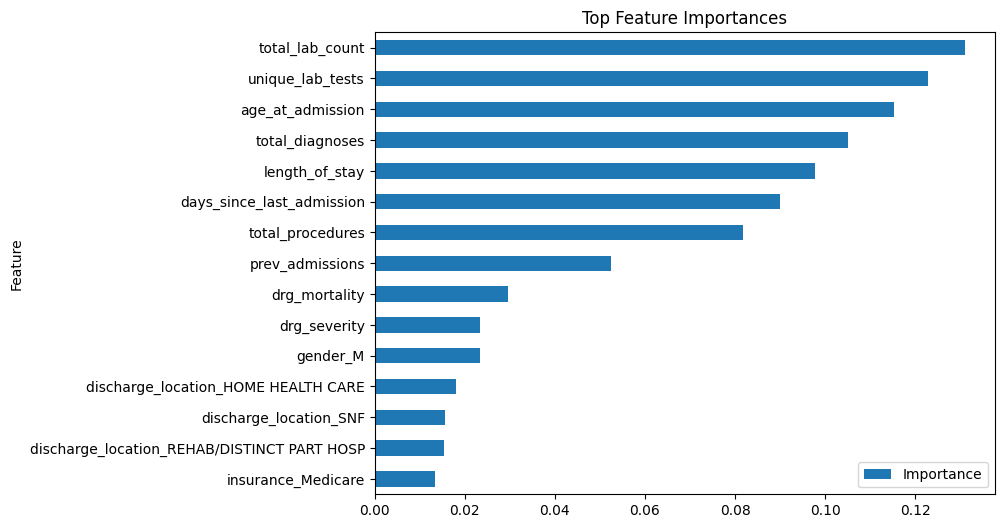

In [31]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
feat_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

feat_imp_df.head(15).plot(x='Feature', y='Importance', kind='barh', figsize=(8,6), title='Top Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [32]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5488505747126436

Classification Report:
               precision    recall  f1-score   support

       False       0.58      0.53      0.55       183
        True       0.52      0.57      0.54       165

    accuracy                           0.55       348
   macro avg       0.55      0.55      0.55       348
weighted avg       0.55      0.55      0.55       348



# Feature engineering to improve accuracy

In [33]:
final_df3 = hf_df[feature_columns + ['readmitted_30days']].copy()
final_df3

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,age_at_admission,gender,length_of_stay,admission_type,discharge_location,insurance,total_diagnoses,total_procedures,prev_admissions,days_since_last_admission,drg_severity,drg_mortality,unique_lab_tests,total_lab_count,readmitted_30days
5,300.0,M,1,EMERGENCY,HOME,Medicare,8,3.0,0,NaN,3.0,3.0,55.0,96.0,False
14,42.0,F,19,EMERGENCY,HOME HEALTH CARE,Medicare,13,4.0,0,NaN,4.0,3.0,117.0,523.0,True
25,48.0,M,6,ELECTIVE,HOME,Private,7,2.0,0,NaN,NaN,NaN,40.0,185.0,False
26,50.0,M,20,EMERGENCY,HOME,Private,15,5.0,1,782.0,NaN,NaN,55.0,705.0,False
32,63.0,M,20,EMERGENCY,SNF,Private,9,5.0,0,NaN,NaN,NaN,95.0,815.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14017,75.0,F,4,EMERGENCY,HOME HEALTH CARE,Medicare,20,1.0,0,NaN,3.0,4.0,93.0,200.0,False
14027,74.0,M,3,EMERGENCY,HOME,Medicare,10,5.0,0,NaN,3.0,3.0,49.0,155.0,False
14030,54.0,M,1,EMERGENCY,HOME,Private,19,0.0,0,NaN,4.0,3.0,42.0,88.0,False
14035,65.0,M,10,EMERGENCY,HOME HEALTH CARE,Medicare,9,2.0,0,NaN,3.0,3.0,46.0,497.0,True


In [34]:
final_df3['gender'].value_counts()

gender
M    1907
F    1697
Name: count, dtype: int64

In [35]:
final_df3['admission_type'].value_counts()

admission_type
EMERGENCY    3214
ELECTIVE      298
URGENT         92
Name: count, dtype: int64

In [36]:
final_df3['insurance'].value_counts()

insurance
Medicare      2740
Private        558
Medicaid       261
Government      41
Self Pay         4
Name: count, dtype: int64

In [37]:
categorical_features = ['gender', 'admission_type', 'insurance']
final_df3 = pd.get_dummies(final_df3, columns=categorical_features, drop_first=True)

In [38]:
final_df3['criticality_score'] = final_df3['drg_severity'] * final_df3['drg_mortality']

In [39]:
final_df3['chronicity_index'] = final_df3['prev_admissions'] * final_df3['length_of_stay']

In [40]:
final_df3['procedure_intensity'] = final_df3['total_procedures'] / (final_df3['length_of_stay'] + 1e-5)
final_df3.drop(['total_procedures'], axis=1, inplace=True)
final_df3['repeat_test_rate'] = final_df3['total_lab_count'] / (final_df3['unique_lab_tests'] + 1e-5)

In [41]:
final_df3.drop(['prev_admissions', 'length_of_stay'], axis=1, inplace=True)

In [42]:
final_df3

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,age_at_admission,discharge_location,total_diagnoses,days_since_last_admission,drg_severity,drg_mortality,unique_lab_tests,total_lab_count,readmitted_30days,gender_M,admission_type_EMERGENCY,admission_type_URGENT,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,criticality_score,chronicity_index,procedure_intensity,repeat_test_rate
5,300.0,HOME,8,NaN,3.0,3.0,55.0,96.0,False,True,True,False,False,True,False,False,9.0,0,2.999970,1.745454
14,42.0,HOME HEALTH CARE,13,NaN,4.0,3.0,117.0,523.0,True,False,True,False,False,True,False,False,12.0,0,0.210526,4.470085
25,48.0,HOME,7,NaN,NaN,NaN,40.0,185.0,False,True,False,False,False,False,True,False,NaN,0,0.333333,4.624999
26,50.0,HOME,15,782.0,NaN,NaN,55.0,705.0,False,True,True,False,False,False,True,False,NaN,20,0.250000,12.818179
32,63.0,SNF,9,NaN,NaN,NaN,95.0,815.0,False,True,True,False,False,False,True,False,NaN,0,0.250000,8.578946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14017,75.0,HOME HEALTH CARE,20,NaN,3.0,4.0,93.0,200.0,False,False,True,False,False,True,False,False,12.0,0,0.249999,2.150537
14027,74.0,HOME,10,NaN,3.0,3.0,49.0,155.0,False,True,True,False,False,True,False,False,9.0,0,1.666661,3.163265
14030,54.0,HOME,19,NaN,4.0,3.0,42.0,88.0,False,True,True,False,False,False,True,False,12.0,0,0.000000,2.095238
14035,65.0,HOME HEALTH CARE,9,NaN,3.0,3.0,46.0,497.0,True,True,True,False,False,True,False,False,9.0,0,0.200000,10.804345


In [43]:
freq = final_df3['discharge_location'].value_counts()
rare = freq[freq<50].index
final_df3['discharge_location']= final_df3['discharge_location'].replace(rare,'Other')

In [44]:
final_df3['discharge_location'].value_counts()

discharge_location
HOME HEALTH CARE             1099
SNF                           872
HOME                          627
REHAB/DISTINCT PART HOSP      602
LONG TERM CARE HOSPITAL       305
DISC-TRAN CANCER/CHLDRN H      55
Other                          44
Name: count, dtype: int64

In [45]:
final_df3 = pd.get_dummies(final_df3, columns = ['discharge_location'], drop_first = True)
final_df3

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,age_at_admission,total_diagnoses,days_since_last_admission,drg_severity,drg_mortality,unique_lab_tests,total_lab_count,readmitted_30days,gender_M,admission_type_EMERGENCY,...,criticality_score,chronicity_index,procedure_intensity,repeat_test_rate,discharge_location_HOME,discharge_location_HOME HEALTH CARE,discharge_location_LONG TERM CARE HOSPITAL,discharge_location_Other,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SNF
5,300.0,8,NaN,3.0,3.0,55.0,96.0,False,True,True,...,9.0,0,2.999970,1.745454,True,False,False,False,False,False
14,42.0,13,NaN,4.0,3.0,117.0,523.0,True,False,True,...,12.0,0,0.210526,4.470085,False,True,False,False,False,False
25,48.0,7,NaN,NaN,NaN,40.0,185.0,False,True,False,...,NaN,0,0.333333,4.624999,True,False,False,False,False,False
26,50.0,15,782.0,NaN,NaN,55.0,705.0,False,True,True,...,NaN,20,0.250000,12.818179,True,False,False,False,False,False
32,63.0,9,NaN,NaN,NaN,95.0,815.0,False,True,True,...,NaN,0,0.250000,8.578946,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14017,75.0,20,NaN,3.0,4.0,93.0,200.0,False,False,True,...,12.0,0,0.249999,2.150537,False,True,False,False,False,False
14027,74.0,10,NaN,3.0,3.0,49.0,155.0,False,True,True,...,9.0,0,1.666661,3.163265,True,False,False,False,False,False
14030,54.0,19,NaN,4.0,3.0,42.0,88.0,False,True,True,...,12.0,0,0.000000,2.095238,True,False,False,False,False,False
14035,65.0,9,NaN,3.0,3.0,46.0,497.0,True,True,True,...,9.0,0,0.200000,10.804345,False,True,False,False,False,False


In [46]:
final_df3.shape

(3604, 25)

In [47]:
final_df3 = final_df3.fillna(final_df3.median())
final_df3.drop(final_df3[final_df3['age_at_admission'] > 120].index, inplace=True)

# Creating a balanced dataset

In [48]:
from imblearn.over_sampling import SMOTE

X = final_df3.drop(columns=['readmitted_30days'])  
y = final_df3['readmitted_30days']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='readmitted_30days')
X_resampled= X_resampled.round(1)
balanced_df = pd.concat([X_resampled, y_resampled], axis=1)

In [49]:
balanced_df = balanced_df.round(1)

# Splitting the dataset and training the model again on improved dataset

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

Accuracy: 0.8163900414937759

Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.89      0.83       472
        True       0.88      0.75      0.81       492

    accuracy                           0.82       964
   macro avg       0.82      0.82      0.82       964
weighted avg       0.82      0.82      0.82       964



In [51]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7842323651452282

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.85      0.79       472
        True       0.83      0.72      0.77       492

    accuracy                           0.78       964
   macro avg       0.79      0.79      0.78       964
weighted avg       0.79      0.78      0.78       964



# Saving the final dataset

In [52]:
balanced_df.to_csv("heart_failure_readmission_81.csv", index= True)

# Exporting the best model

In [53]:
import joblib
joblib.dump({
    'model': clf,
    'features': X_train.columns.tolist()
}, 'best_clf.pkl')

['best_clf.pkl']

# Finding readmission risk percentage

In [54]:
import numpy as np
test = (np.array(X_test.iloc[0:1]))

In [55]:
clf.predict_proba(test)[0][1]

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.9